# Setup

In [14]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import random
import seaborn as sns

dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v1_poreC_explore/'

runDir1 = 'v1.evaluateExpectedVersusInteresting_NlaIII_HG002/'
plotDir1 = f'{dataDir}{runDir1}Plots_chr8/'
outDir1 = f'{dataDir}{runDir1}dfs_chr8/'

runDir2 = 'v1.evaluateExpectedVersusInteresting_NlaIII_HCC1954/'
plotDir2 = f'{dataDir}{runDir2}Plots_chr8/'
outDir2 = f'{dataDir}{runDir2}dfs_chr8/'

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from chains import dictToDF, dfToDict
from incidenceToProjection import makeHiC_fromInc, fillInGaps_realData, makeNorm_HiC_fromInc
from edgeWeightFormulations import finalBounded

# Basic checks

In [2]:
card = 3

coSimFile_hg = pd.read_csv(f'{outDir1}cosineSim_card{card}.csv',sep = "\t")
empDistFile_hg = pd.read_csv(f'{outDir1}empDist_card{card}.csv',sep = "\t")

coSimFile_hcc = pd.read_csv(f'{outDir2}cosineSim_card{card}.csv',sep = "\t")
empDistFile_hcc = pd.read_csv(f'{outDir2}empDist_card{card}.csv',sep = "\t")

In [3]:
print(empDistFile_hg.head())
empDistFile_hg.shape

       3Sub2  Edge_ix  ReadSupport  Status
0   1.284965    14823            2       1
1   5.384584     5667            2       0
2   9.343718    14061            4       0
3  38.389729    10193            2       0
4   2.010884    12625            3       0


(5578, 4)

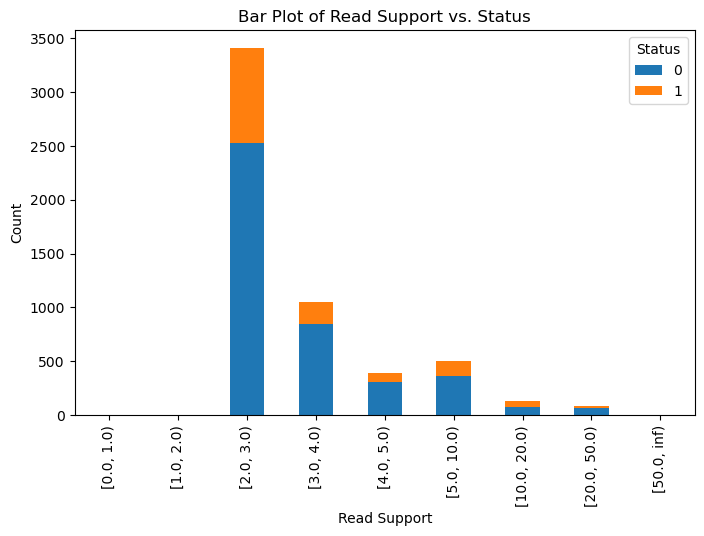

In [18]:
empDistFile = empDistFile_hg.copy()

bins = [0, 1, 2, 3, 4, 5, 10, 20,50, float('inf')]
empDistFile['ReadSupportBin'] = pd.cut(empDistFile['ReadSupport'], bins=bins, right=False)
grouped_empDist = empDistFile.groupby(['ReadSupportBin', 'Status']).size().unstack(fill_value=0)

# Plot the bar plot
ax = grouped_empDist.plot(kind='bar', stacked=True, figsize=(8, 5))

# Set labels and title
ax.set_xlabel('Read Support')
ax.set_ylabel('Count')
ax.set_title('Bar Plot of Read Support vs. Status')

# Show the plot
plt.show()

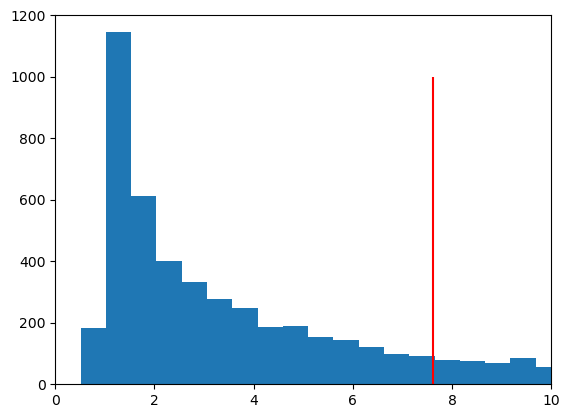

In [19]:
def getCutoff(summaryDF,quartile):
    q = f'{quartile}%'
    cutoff = pd.Series(summaryDF['mean']).describe()[q]
    return(cutoff)


empDistFile = empDistFile_hg.copy()

summary_empDist = empDistFile.filter(like="Sub").apply(lambda row: [np.mean(row), np.std(row)], axis=1, result_type='expand')
summary_empDist.columns = ['mean','sd']
empdistCutoff = getCutoff(summary_empDist,75)
p = plt.hist(summary_empDist['mean'],bins=2000)
plt.xlim(0,10)
plt.vlines(empdistCutoff, ymin = 0, ymax=1000,colors="red")
plt.show()
empdistStatus = [1 if x else 0 for x in (summary_empDist['mean'] >= empdistCutoff)]

In [20]:
agreement_status = ["Agree:Interesting" if v1 == 1 and v2 == 1 else 
                    "CoSim only" if v1 == 1 else "empDist only" if v2 == 1 
                    else "Expected" for 
                    v1, v2 in zip(coSimFile_hg['Status'], empdistStatus)]

Text(0.5, 0.98, '3Sub2')

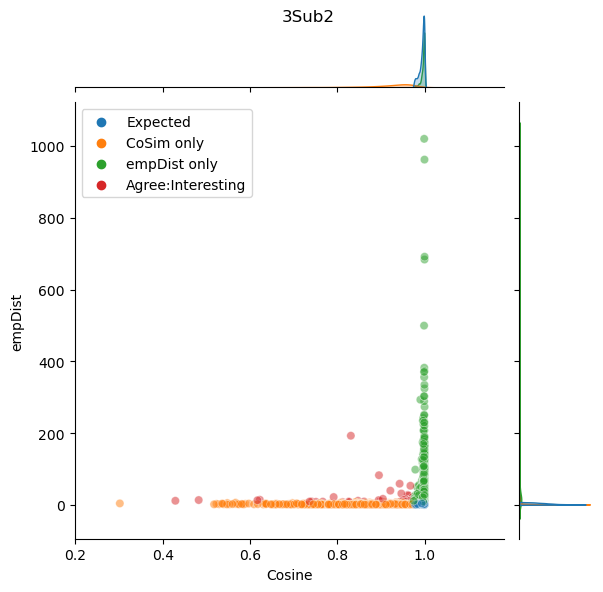

In [21]:
legend_order = ["Expected","CoSim only", "empDist only","Agree:Interesting"]

#plt.figure(figsize=(8, 4))
cos = coSimFile_hg['3Sub2']
empDist = empDistFile_hg['3Sub2']
j1 = sns.jointplot(x=cos, y=empDist, kind="scatter", 
                   hue=agreement_status, hue_order=legend_order, alpha = 0.5)
j1.set_axis_labels('Cosine', 'empDist', fontsize=10)
j1.fig.suptitle("3Sub2")
#axes[0].set_title('5Sub2')

In [23]:
with open(f'{dataDir}{runDir1}hyperEdges_HG002_chr8.pkl','rb') as f:
    hpEdges = pickle.load(f)

print("Processing all the hyperedges from pickle file")
hpKeys = [k for k in hpEdges.keys()]
print("A total of",len(hpKeys),"initial interactions")

readSupport = [v for v in hpEdges.values()]
atLeastTwoChains = [i for i,x in enumerate(readSupport) if x >=2]
updatedDict = {hpKeys[i]:readSupport[i] for i in atLeastTwoChains}

hpKeys = [k for k in updatedDict.keys()]
hpKeys_split = [k.split("_") for k in updatedDict.keys()]
keyCard = [len(item) for item in hpKeys_split]

Processing all the hyperedges from pickle file
A total of 69928 initial interactions


In [25]:
print(len(agreement_status))
consensusIx = [coSimFile_hg['Edge_ix'][ix] for ix,x in enumerate(agreement_status) if x == "Agree:Interesting"]
print(len(consensusIx))
randList = random.sample(range(coSimFile_hg.shape[0]),len(consensusIx))

subsetKeys = [hpKeys[ix] for ix in consensusIx]
subsetKeyCard = [keyCard[ix] for ix in consensusIx]

5578
57


In [26]:
subsetDict = {key: updatedDict[key] for key in subsetKeys}
subset_incDF = dictToDF(subsetDict)
finalBoundedScores = [finalBounded(list(subset_incDF[c])) for c in subset_incDF.columns]

In [27]:
rsubsetKeys = [hpKeys[ix] for ix in randList]
rsubsetKeyCard = [keyCard[ix] for ix in randList]
rsubsetDict = {key: updatedDict[key] for key in rsubsetKeys}
rsubset_incDF = dictToDF(rsubsetDict)

randomBoundedScores = [finalBounded(list(rsubset_incDF[c])) for c in rsubset_incDF.columns]

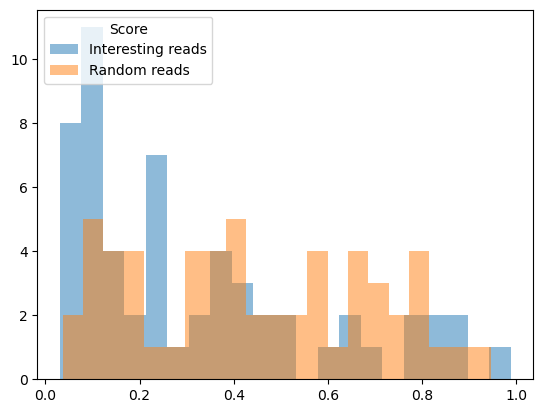

In [28]:
plt.hist(finalBoundedScores,bins = 21,alpha =0.5)
plt.hist(randomBoundedScores,bins = 21,alpha =0.5)
plt.legend(title="Score",loc="upper left",labels = ("Interesting reads","Random reads"))

In [29]:
fullDF = fillInGaps_realData(subset_incDF,"Bin",1)
projMat = makeHiC_fromInc(fullDF)
# projMat_weighted = makeNorm_HiC_fromInc(fullDF,finalBoundedScores)

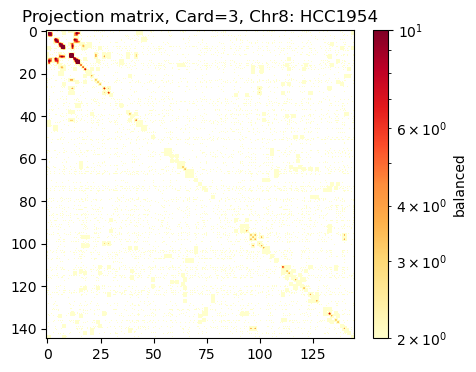

In [30]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(projMat, cmap="YlOrRd",norm = LogNorm(vmax = 10))
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"Projection matrix, Card={card}, Chr8: HCC1954")
plt.show()

In [171]:
### Original matrix

ogDF = dictToDF(updatedDict)
ogProjMat = makeHiC_fromInc(ogDF)

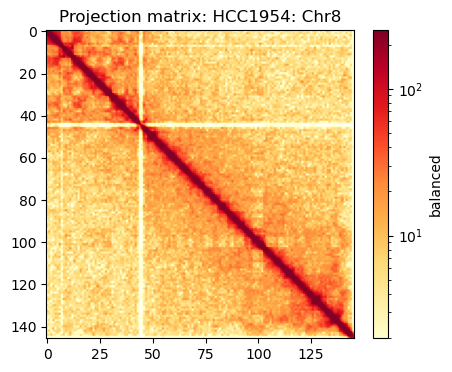

In [172]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(ogProjMat, cmap="YlOrRd",norm = LogNorm(vmax = 250))
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"Projection matrix: HCC1954: Chr8")
plt.show()

In [37]:
## Original 2-way matrix
twoWay = [k for k in hpEdges.keys() if len(k.split("_")) == 2]
twoWayDict = {k:v for k,v in hpEdges.items() if k in twoWay and v >= 2}

In [40]:
twoWayIncDF = dictToDF(twoWayDict)
towWayProjMat = makeHiC_fromInc(twoWayIncDF)

In [195]:
## Original 3-way 
threeWay = [k for k in hpEdges.keys() if len(k.split("_")) == 3]
threeWayDict = {k:v for k,v in hpEdges.items() if k in threeWay and v >= 2}
threeWayIncDF = dictToDF(threeWayDict)
threeWayProjMat = makeHiC_fromInc(threeWayIncDF)

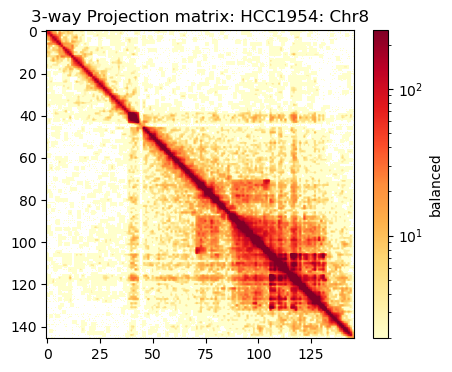

In [196]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(threeWayProjMat, cmap="YlOrRd",norm = LogNorm(vmax = 250))
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"3-way Projection matrix: HCC1954: Chr8")
plt.show()

In [17]:
subsetDict_hcc = subsetDict
subset_incDF_hcc = subset_incDF
finalBoundedScores_hcc = finalBoundedScores
updatedDict_hcc = updatedDict
hpEdges_hcc = hpEdges
fullDF_hcc = fullDF
# twoWayDict_hcc = twoWayDict


In [31]:
subsetDict_hg = subsetDict
subset_incDF_hg = subset_incDF
finalBoundedScores_hg = finalBoundedScores
updatedDict_hg = updatedDict
hpEdges_hg = hpEdges
fullDF_hg = fullDF

In [92]:
# a = fullDF.copy()
# b = fullDF.copy()
# c = pd.concat([a,b],axis = 1)
projMat = makeHiC_fromInc(c)

# Hypergraph analysis

In [43]:
import hypernetx as hnx
import networkx as nx

#HCC1954
HIS_hcc = hnx.Hypergraph.from_incidence_dataframe(subset_incDF_hcc)
weights_hcc = pd.Series(finalBoundedScores_hcc, index = subset_incDF_hcc.columns)

for e in HIS_hcc.edges:
    HIS_hcc.edges[e].weight = weights_hcc[e]

## HG002
HIS = hnx.Hypergraph.from_incidence_dataframe(subset_incDF)
weights = pd.Series(finalBoundedScores, index = subset_incDF.columns)

for e in HIS.edges:
    HIS.edges[e].weight = weights[e]

 No module named 'celluloid'. If you need to use hypernetx.algorithms.contagion, please install additional packages by running the following command: pip install .['all']


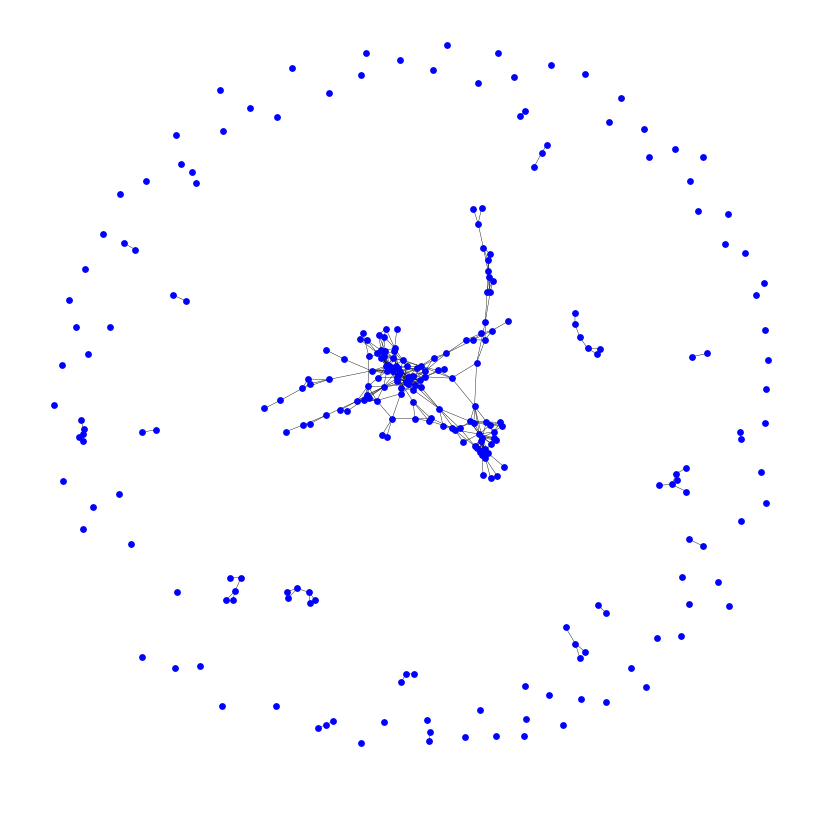

In [149]:
l_hcc = HIS_hcc.get_linegraph(s = 3)
nx.draw(l_hcc,node_size = 15, node_color = "blue",width = 0.3)

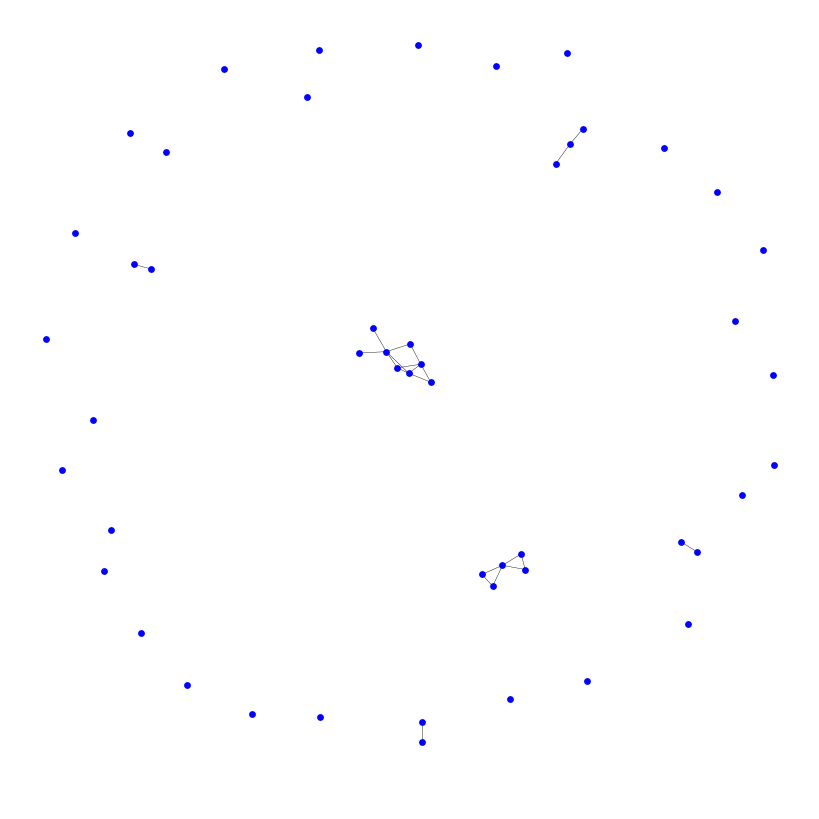

In [143]:
l = HIS.get_linegraph(s = 2)
nx.draw(l,node_size = 15, node_color = "blue",width = 0.3)

In [150]:
HIS_hcc.edge_diameters(s=3)

(14,
 [0,
  3,
  0,
  0,
  0,
  4,
  1,
  14,
  0,
  0,
  1,
  2,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  1,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [{'Read100:2'},
  {'Read101:4', 'Read118:6', 'Read148:2', 'Read240:2', 'Read253:7'},
  {'Read102:2'},
  {'Read103:2'},
  {'Read104:2'},
  {'Read105:2', 'Read144:2', 'Read150:2', 'Read198:2', 'Read48:2', 'Read85:2'},
  {'Read106:2', 'Read19:2'},
  {'Read107:5',
   'Read108:2',
   'Read109:2',
   'Read112:7',
   'Read113:3',
   'Read114:8',
   'Read116:2',
   'Read119:3',
   'Read120:2',
   'Read121:28',
   'Read124:4',
   'Read125:4',
   'Read127:14',
   'Read129:2',
   'Read135

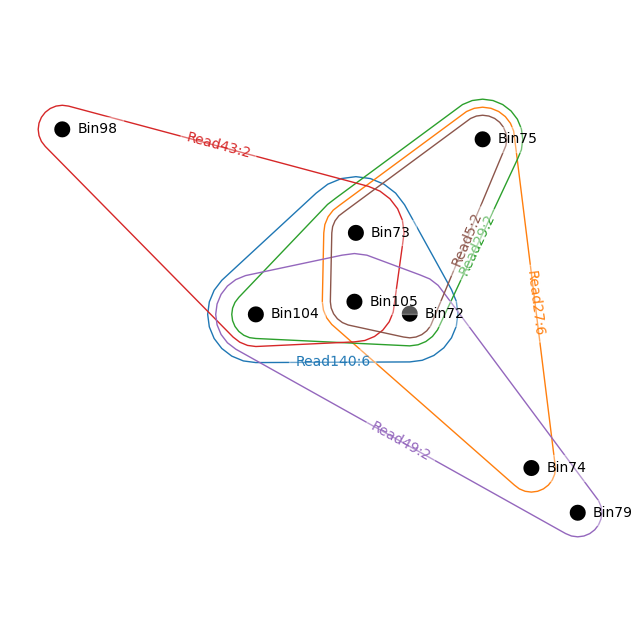

In [152]:
hnx.draw(HIS_hcc.restrict_to_edges(['Read140:6',
                                 'Read27:6', 'Read29:2', 'Read43:2', 'Read49:2', 'Read5:2']))

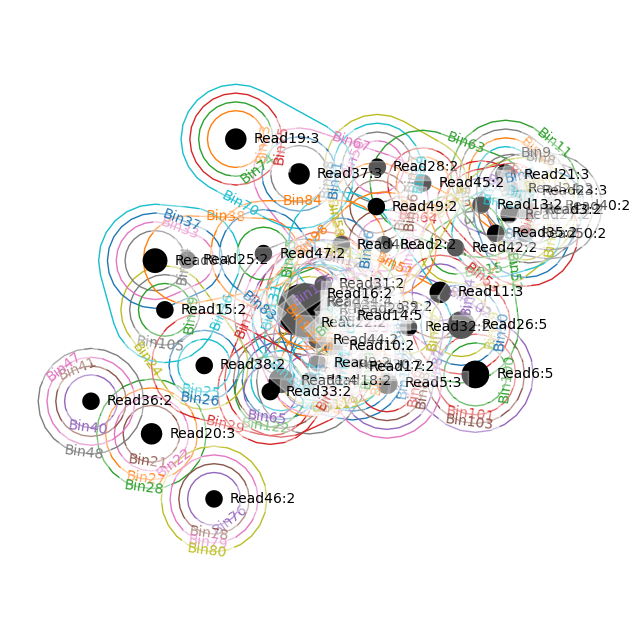

In [77]:
hnx.draw(HIS.dual())

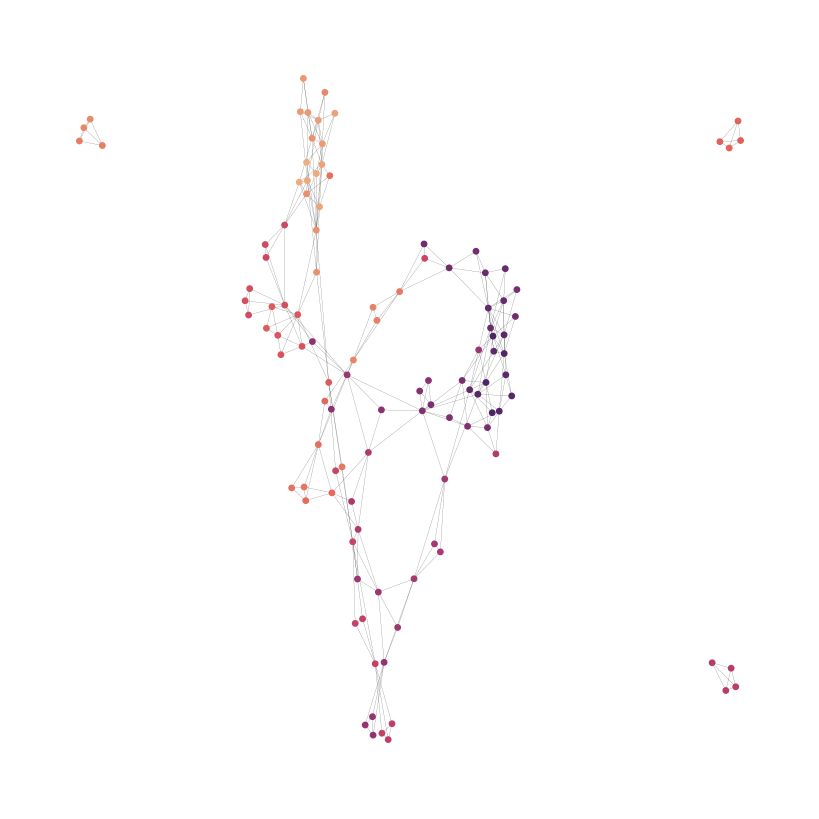

In [113]:
def sort_key(item, delimiter):
    return int(item.split(delimiter)[1])

node_names = sorted(list(HIS.nodes()), key=lambda x: sort_key(x,'Bin'))
node_colors = sns.color_palette("flare", n_colors=len(node_names))
color_mapping = dict(zip(node_names, node_colors))

HD = HIS.dual()
l = HD.get_linegraph(s = 1)
nx.draw(l,node_size = 15, 
        #with_labels = True, 
        node_color=[color_mapping[node] for node in l.nodes],
        width = 0.1,
        font_size=5)

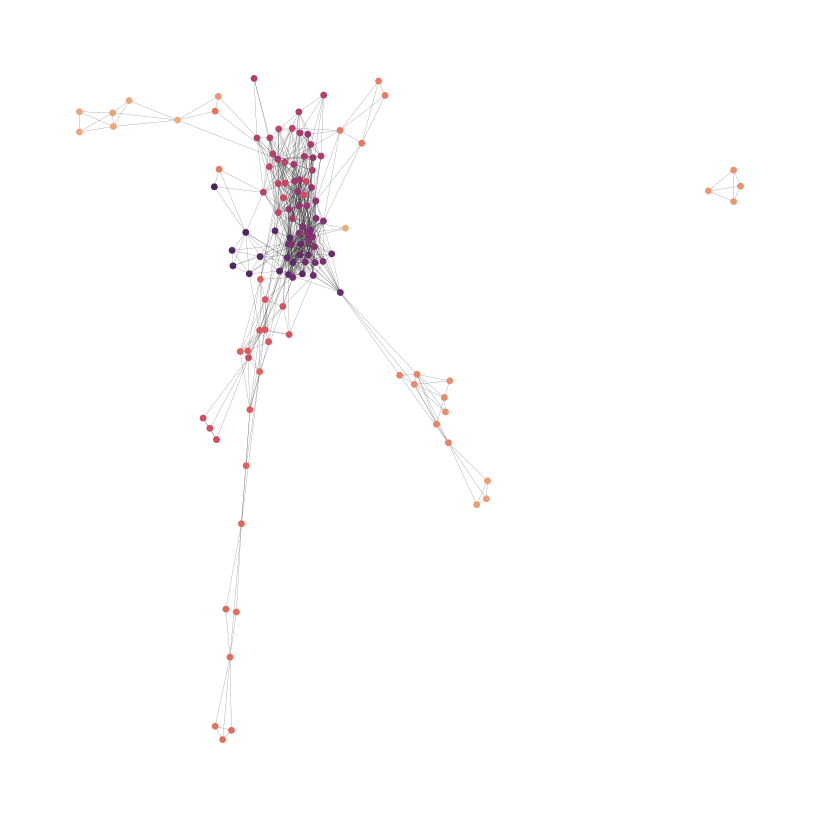

In [112]:
node_names = sorted(list(HIS_hcc.nodes()), key=lambda x: sort_key(x,'Bin'))
node_colors = sns.color_palette("flare", n_colors=len(node_names))
color_mapping = dict(zip(node_names, node_colors))

HCC_D = HIS_hcc.dual()
l_hcc = HCC_D.get_linegraph(s = 1)
nx.draw(l_hcc,node_size = 15, 
        #with_labels = True, 
        node_color=[color_mapping[node] for node in l_hcc.nodes],
        width = 0.1,
        font_size=5)

34

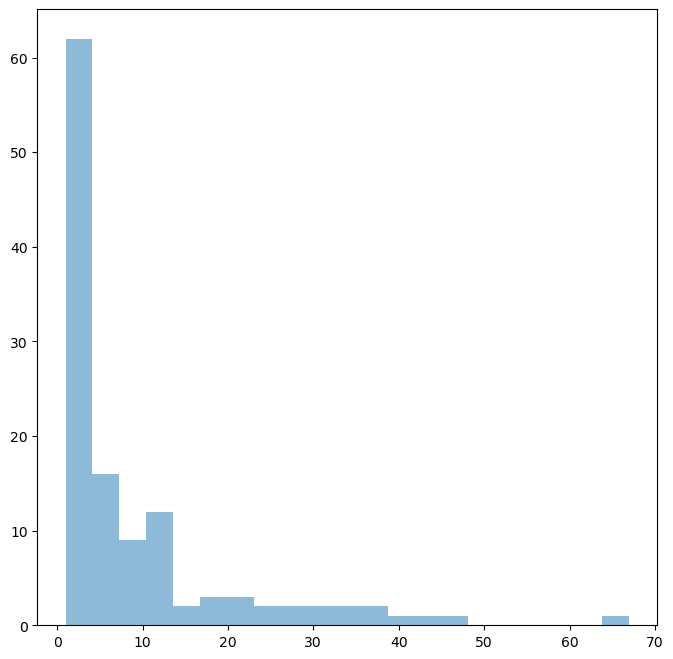

In [55]:
subset_incDF_hcc
rowSums_hcc = subset_incDF_hcc.sum(axis=1)
rowSums_hg = subset_incDF.sum(axis=1)
plt.hist(rowSums_hcc,alpha =0.5,bins = 21)

len(rowSums_hcc[rowSums_hcc > 10])

In [61]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(fullDF_hcc)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result)

Explained Variance Ratio:
[1.15030655e-01 6.62432576e-02 4.79200803e-02 4.33233909e-02
 3.78572782e-02 3.56386936e-02 3.18425768e-02 2.85402906e-02
 2.69620870e-02 2.52143560e-02 2.28723504e-02 2.18711593e-02
 2.00141404e-02 1.91790429e-02 1.89722426e-02 1.83276175e-02
 1.81735982e-02 1.68515424e-02 1.51498967e-02 1.47441203e-02
 1.41315498e-02 1.35535954e-02 1.33015088e-02 1.27991469e-02
 1.21343121e-02 1.19462887e-02 1.07745620e-02 1.04844302e-02
 1.02114620e-02 9.62928000e-03 9.29206393e-03 9.01953598e-03
 8.32662973e-03 8.21389457e-03 7.65848905e-03 7.34147418e-03
 7.18588021e-03 7.15905453e-03 6.78807257e-03 6.71562003e-03
 6.51363800e-03 6.33345065e-03 6.05805051e-03 5.77904079e-03
 5.62481842e-03 5.50681410e-03 5.35463126e-03 5.26462088e-03
 5.11512355e-03 5.00981332e-03 4.92209506e-03 4.71692379e-03
 4.58739766e-03 4.45332838e-03 4.35454363e-03 4.22949143e-03
 4.18771236e-03 4.05364629e-03 3.89922423e-03 3.86871103e-03
 3.70553661e-03 3.65389772e-03 3.43110723e-03 3.26371675e-0

In [63]:
pca.components_

array([[ 0.08449415,  0.04693181, -0.01302305, ...,  0.07330522,
         0.0332849 ,  0.08014065],
       [-0.0591968 ,  0.10318085, -0.0085696 , ..., -0.03104555,
         0.00669364,  0.0488825 ],
       [-0.05273214,  0.08827528, -0.0091126 , ...,  0.0360169 ,
         0.20867294, -0.01245594],
       ...,
       [ 0.06599842,  0.0046653 , -0.00031167, ...,  0.04219136,
        -0.02935539,  0.02429895],
       [-0.01214155,  0.05214114, -0.0937967 , ...,  0.03822226,
         0.01628919, -0.01618532],
       [-0.02847367, -0.02587628, -0.12787655, ..., -0.068744  ,
        -0.00093158,  0.06712716]])

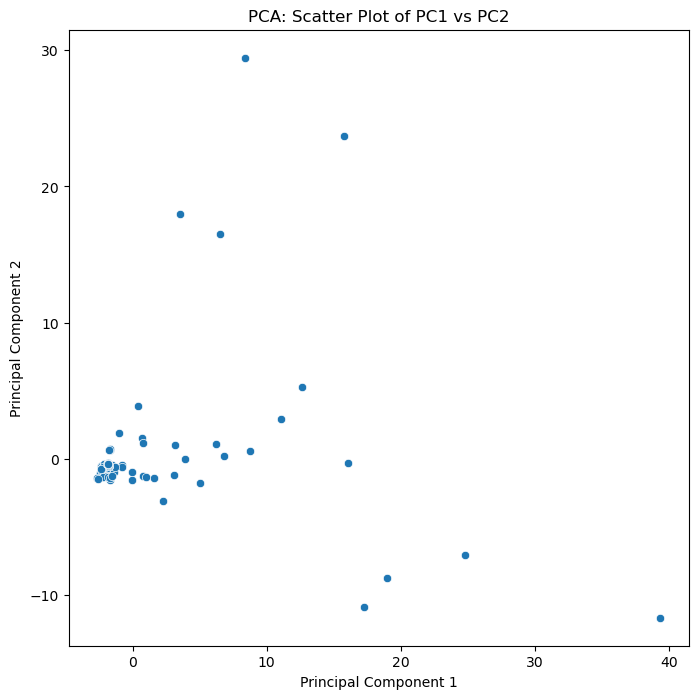

In [64]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC_{i}' for i in range(1, fullDF_hcc.shape[0] +1)])

# Scatter plot of the first two principal components
sns.scatterplot(x='PC_1', y='PC_2', data=pca_df)
plt.title('PCA: Scatter Plot of PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


# Quick stats (QC) - all cell lines

In [3]:
import os

cardList = []
numReadList = []
chromList = []
cellLine = []

for cL in ['HG002','HCC1954','GM12878']:
    runDir = f'v1.evaluateExpectedVersusInteresting_NlaIII_{cL}/'
    for chr in range(1,23):
        outDir = f'{dataDir}{runDir}dfs_chr{chr}/'
        fileList = [file for file in os.listdir(outDir) if 'empDist' in file]
        for file in fileList:
            df = pd.read_csv(f'{outDir}{file}',sep = "\t")
            card = df.shape[1] - 1
            numReads = df.shape[0]
            cardList.append(card)
            numReadList.append(numReads)
            chromList.append(f"chr{chr}")
            cellLine.append(cL)

In [4]:
combinedCounts = pd.DataFrame(zip(cardList,numReadList,chromList,cellLine),
                 columns = ["Card","NumReads","Chrom","CellLine"])

In [5]:
combinedCounts.head()

,Card,NumReads,Chrom,CellLine
0,7,5,chr1,HG002
1,5,57,chr1,HG002
2,4,758,chr1,HG002
3,6,10,chr1,HG002
4,3,7705,chr1,HG002


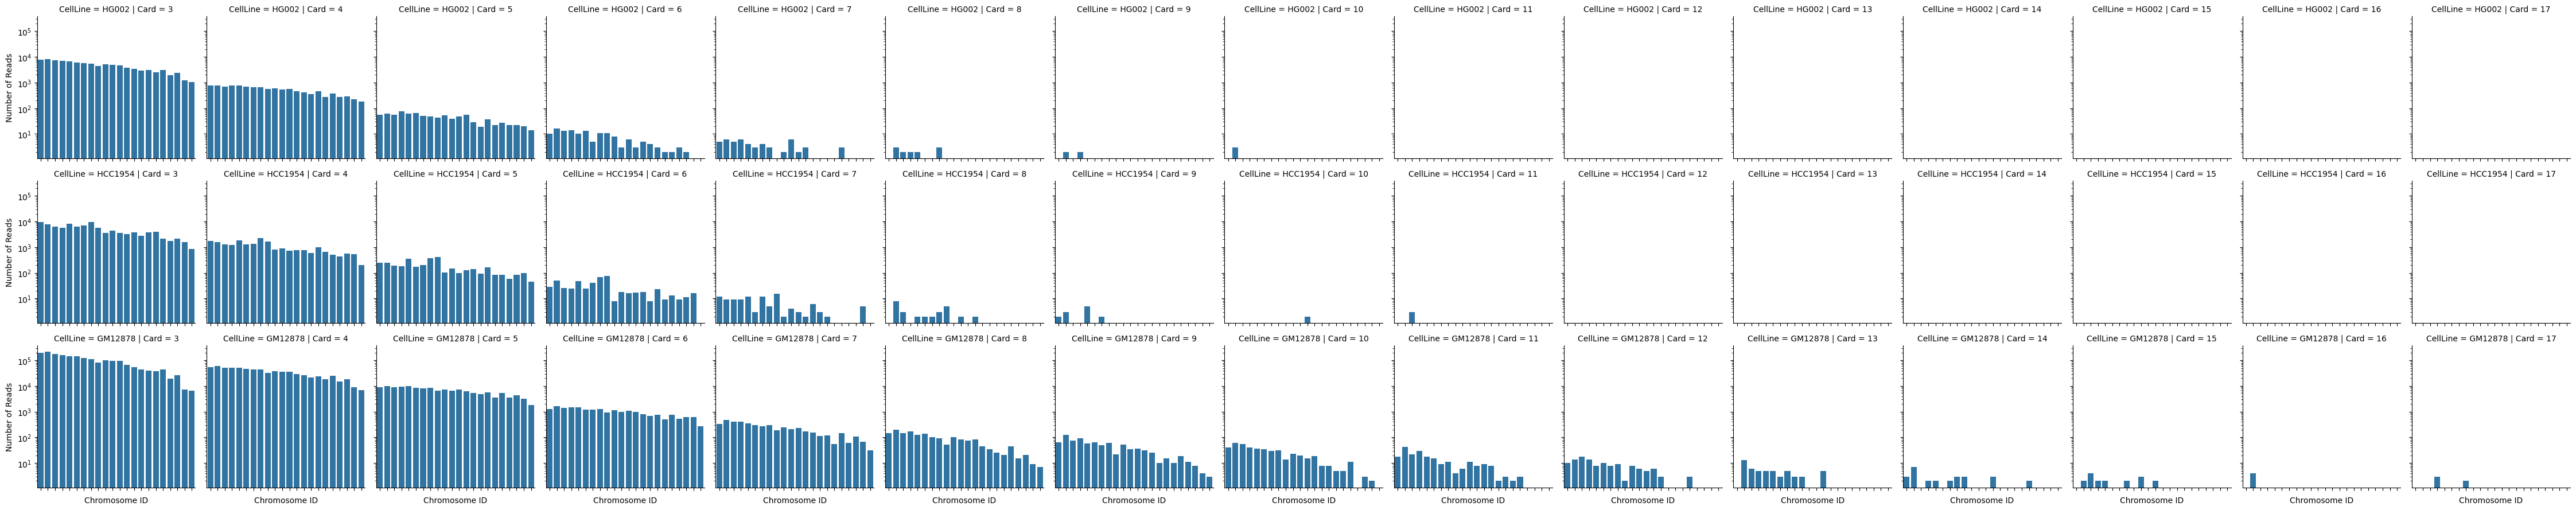

In [6]:
chrom_order = ['chr'+str(i) for i in range(1,23)]

g = sns.FacetGrid(combinedCounts, row='CellLine', 
                  col='Card')

# Map the data to the grid
g.map(sns.barplot, 'Chrom', 'NumReads', 
      log = True, order = chrom_order)

# Set titles and labels
g.set_axis_labels('Chromosome ID', 'Number of Reads')
g.set_xticklabels(rotation=90)
#g.set_titles(col_template="{col_name}", row_template="{row_name} Cardinality")

# Adjust layout
g.tight_layout()

# Show the plot
plt.show()

# Differential analysis

In [32]:
projMat_hcc = makeHiC_fromInc(fullDF_hcc)
projMat_hg = makeHiC_fromInc(fullDF_hg)

In [44]:
projMat_norm_hcc = projMat_hcc / np.nanmax(projMat_hcc)
projMat_norm_hg = projMat_hg / np.nanmax(projMat_hg)

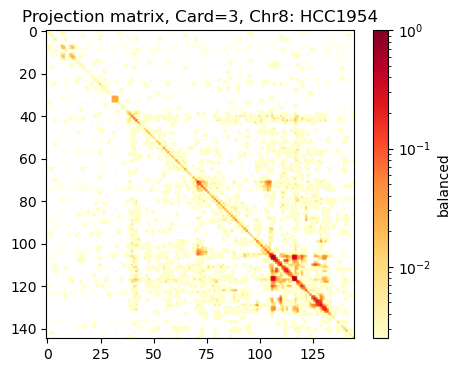

In [43]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(projMat_norm_hcc, cmap="YlOrRd",norm = LogNorm())
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"Projection matrix, Card={card}, Chr8: HCC1954")
plt.show()

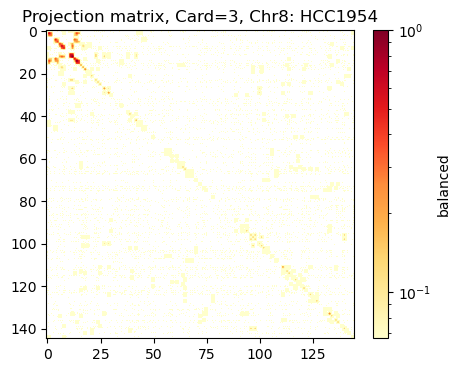

In [45]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(projMat_norm_hg, cmap="YlOrRd",norm = LogNorm())
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"Projection matrix, Card={card}, Chr8: HCC1954")
plt.show()

In [46]:
diffMat = projMat_norm_hcc - projMat_norm_hg

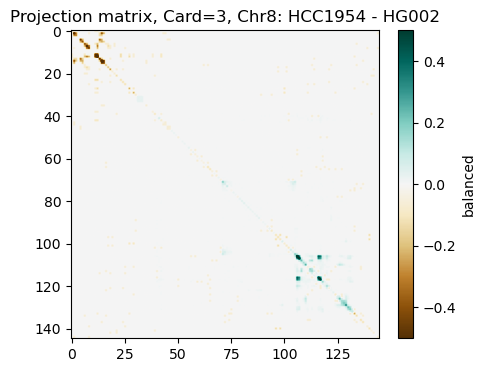

In [213]:
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from matplotlib import colors

plt.figure(figsize=(6, 4))
im = plt.imshow(diffMat, cmap="BrBG",vmin = -0.5, vmax = 0.5)
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"Projection matrix, Card={card}, Chr8: HCC1954 - HG002")
plt.show()

In [177]:
hccEnriched = diffMat.where(diffMat >= 0.1, 0)
hgEnriched =  diffMat.where(diffMat <= -0.1, 0)

positive_rows, positive_columns = (hccEnriched > 0).any(axis=1), (hccEnriched > 0).any()
negative_rows, negative_columns = (hgEnriched < 0).any(axis=1), (hgEnriched < 0).any()

In [178]:
multiwayReads_hcc = subset_incDF_hcc.loc[positive_rows].sum() >= 2
enriched_hcc_incDF = subset_incDF_hcc.loc[positive_rows,multiwayReads_hcc]
print(enriched_hcc_incDF.shape)

multiwayReads_hg = subset_incDF_hg.loc[negative_rows].sum() >= 2
enriched_hg_incDF = subset_incDF_hg.loc[negative_rows,multiwayReads_hg]
enriched_hg_incDF.shape

(19, 139)


(34, 36)

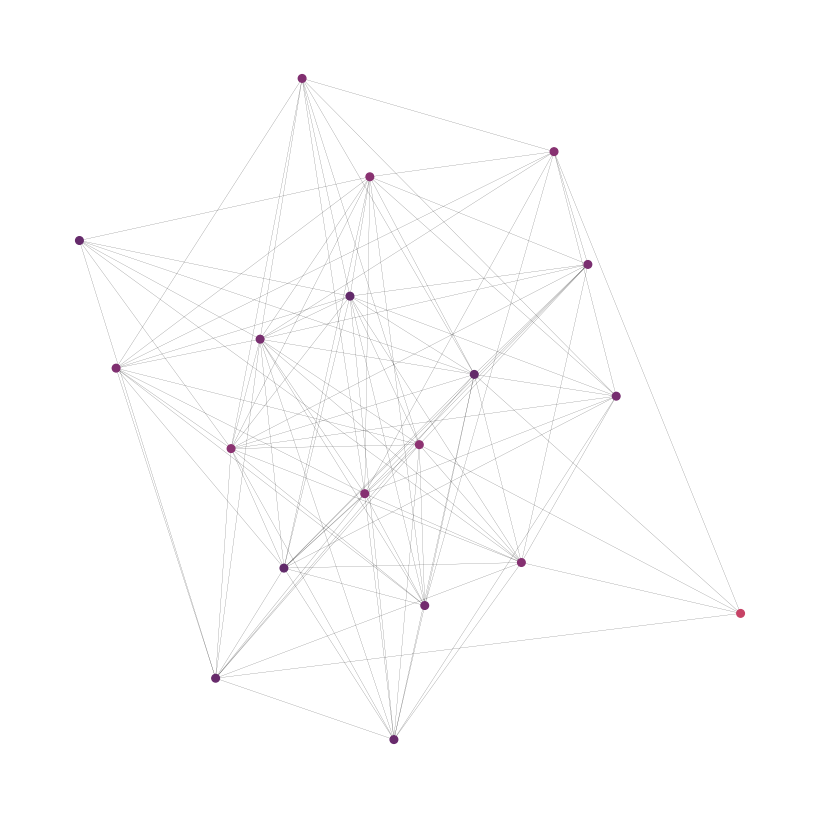

In [215]:
import hypernetx as hnx
import networkx as nx

HIS_hcc = hnx.Hypergraph.from_incidence_dataframe(enriched_hcc_incDF)

def sort_key(item, delimiter):
    return int(item.split(delimiter)[1])

node_names = sorted(list(list(subset_incDF_hcc.index)), key=lambda x: sort_key(x,'Bin'))
node_colors = sns.color_palette("flare", n_colors=len(node_names))
color_mapping = dict(zip(node_names, node_colors))

HCC_D = HIS_hcc.dual()
l_hcc = HCC_D.get_linegraph(s = 1)
nx.draw(l_hcc,node_size = 30, 
        #with_labels = True, 
        node_color=[color_mapping[node] for node in l_hcc.nodes],
        width = 0.1,
        font_size=5)

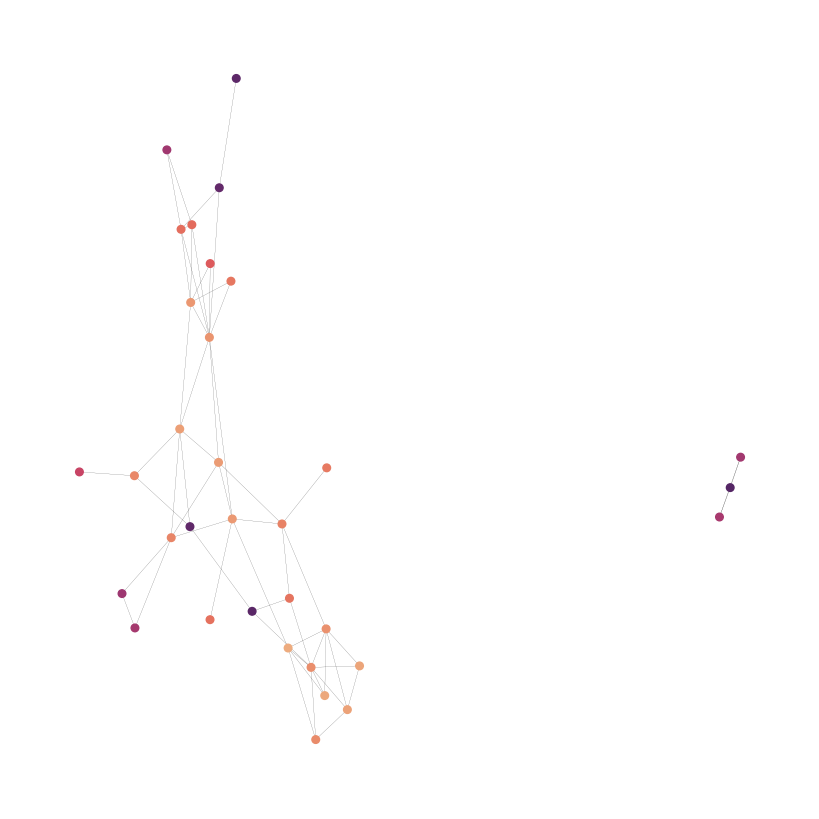

In [214]:
HIS_hg = hnx.Hypergraph.from_incidence_dataframe(enriched_hg_incDF)
node_names = sorted(list(list(subset_incDF_hg.index)), key=lambda x: sort_key(x,'Bin'))
node_colors = sns.color_palette("flare", n_colors=len(node_names))
color_mapping = dict(zip(node_names, node_colors))

HG_D = HIS_hg.dual()
l_hg = HG_D.get_linegraph(s = 1)
nx.draw(l_hg,node_size = 30, 
        #with_labels = True, 
        node_color=[color_mapping[node] for node in l_hg.nodes],
        width = 0.1,
        font_size=5)

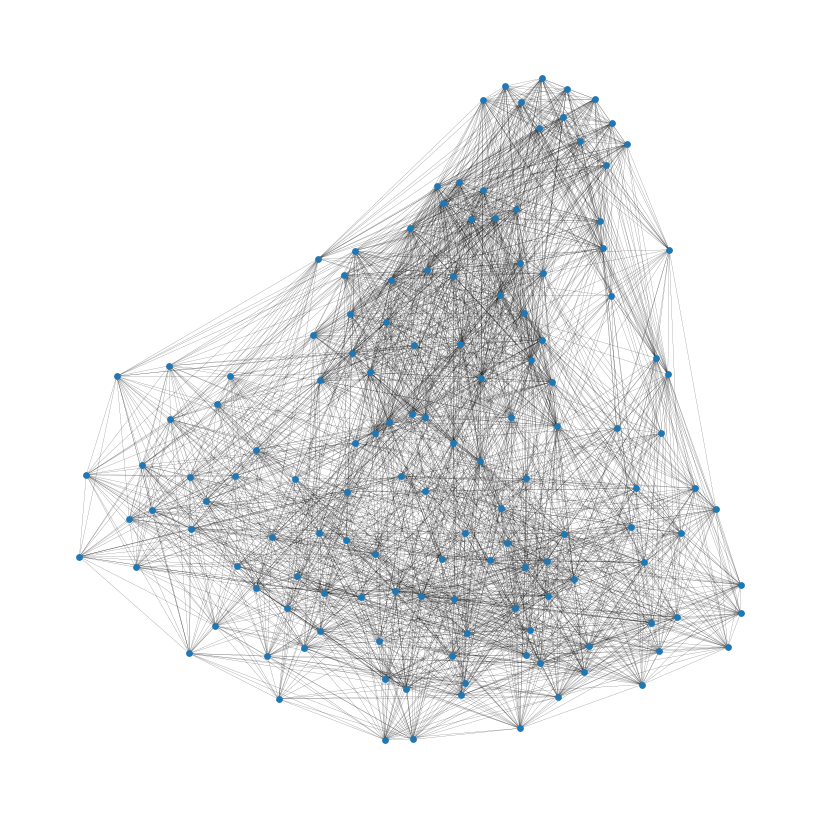

In [181]:
l_hcc_reads = HIS_hcc.get_linegraph(s = 1)
nx.draw(l_hcc_reads,node_size = 15, 
        #with_labels = True, 
        # node_color=[color_mapping[node] for node in l_hcc.nodes],
        width = 0.1,
        font_size=5)

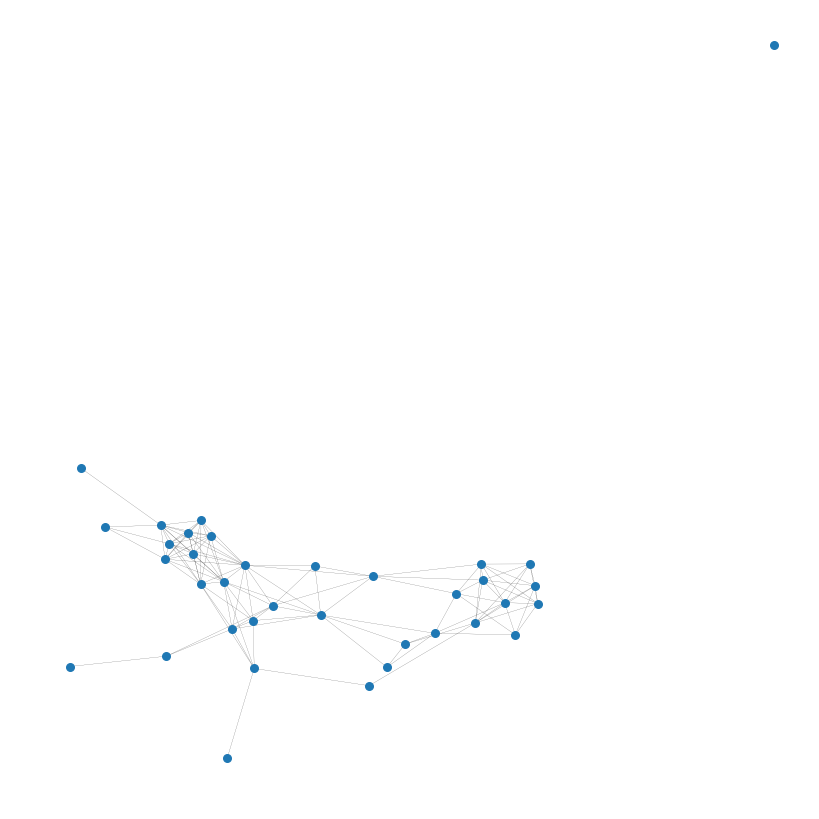

In [216]:
l_hg_reads = HIS_hg.get_linegraph(s = 1)
nx.draw(l_hg_reads,node_size = 30, 
        #with_labels = True, 
        # node_color=[color_mapping[node] for node in l_hcc.nodes],
        width = 0.1,
        font_size=5)

In [206]:
connectedComp_hg = list(list(HG_D.s_components(s=1))[0])
connected_incDF_hg = enriched_hg_incDF.loc[connectedComp_hg]

connected_hg_dict = {}
connected_hg_dict = dfToDict(connected_incDF_hg,connected_hg_dict)
impReads = list(connected_hg_dict.keys())
impReads[0:4]

['Bin2_Bin9', 'Bin2_Bin15_Bin16', 'Bin13_Bin7_Bin12', 'Bin18_Bin7_Bin8']

In [205]:
connectedComp_hcc = list(list(HCC_D.s_components(s=1))[0])
connected_incDF_hcc = enriched_hcc_incDF.loc[connectedComp_hcc]

connected_hcc_dict = {}
connected_hcc_dict = dfToDict(connected_incDF_hcc,connected_hcc_dict)
impReads_hcc = list(connected_hcc_dict.keys())
impReads_hcc[0:4]

['Bin114_Bin121', 'Bin111_Bin128_Bin110', 'Bin106_Bin72', 'Bin107_Bin131']

In [132]:
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v1_poreC_explore/'
chromSizes = pd.read_csv(f'{dataDir}hg38.chromSizes',sep="\t", names = ['chr','size']).set_index('chr')['size'].to_dict()
readConcatemersWClosestGene = f'{dataDir}NlaIII_HG002_output_byChr/NlaIII_HG002_chr8.gz'
colnames = ["chr","start","end","readID","readLen","readQual",
"geneChr","geneStart","geneEnd","strand","geneID","bioType","geneName","dist","ID"]

fullBed = pd.read_csv(readConcatemersWClosestGene,sep = "\t",names = colnames)

In [136]:
chrFile = fullBed[fullBed['chr']=="chr8"]
binSize = 1*10**6 #5*10**5
chrBins = [x for x in range(0,chromSizes['chr2']+binSize,binSize)]
chrFile_binned = pd.cut(chrFile['start'],bins = chrBins, labels = ["Bin"+str(i+1) for i in range(len(chrBins)-1)]).rename("binID")
chrFile_wBinID = chrFile.merge(chrFile_binned,left_index=True,right_index=True)

In [165]:
groupedBins = chrFile_wBinID.groupby('ID')['binID'].apply(list).reset_index(name='Bins')

In [167]:
def sort_key(item):
    return int(item.split('Bin')[1])

edges = ["_".join(sorted(list(set(a)), key=sort_key)) for a in groupedBins['Bins'] if len(list(set(a))) > 1]
readIDs = [groupedBins.iloc[ix][0] for ix in range(len(groupedBins)) if len(list(set(groupedBins.iloc[ix][1]))) > 1]
print(len(edges))
print(len(readIDs))

203579
203579


In [207]:
impReadIDs = [readIDs[i] for i,x in enumerate(edges) if x in impReads]
impReadIDs_hcc = [readIDs[i] for i,x in enumerate(edges) if x in impReads_hcc]

In [171]:
print(groupedBins.head())

chrFile_wBinID.head()

   ID                                Bins
0   1  [Bin1, Bin15, Bin27, Bin35, Bin35]
1   2                        [Bin1, Bin1]
2   3                              [Bin1]
3   4                              [Bin1]
4   5      [Bin1, Bin1, Bin1, Bin1, Bin8]


,chr,start,end,readID,readLen,readQual,geneChr,geneStart,geneEnd,strand,geneID,bioType,geneName,dist,ID,binID
0,chr8,60076,60254,Read:3257236_Card:8_Batch:bdb7b,3000,3,chr8,72601,79775,+,ENSG00000253896,lncRNA,AC144568.2,12348,1,Bin1
1,chr8,62704,64980,Read:5555429_Card:3_Batch:bdb7b,4177,15,chr8,72601,79775,+,ENSG00000253896,lncRNA,AC144568.2,7622,2,Bin1
2,chr8,64921,65063,Read:5555429_Card:3_Batch:bdb7b,4177,15,chr8,72601,79775,+,ENSG00000253896,lncRNA,AC144568.2,7539,2,Bin1
3,chr8,69171,69369,Read:5189686_Card:9_Batch:bdb7b,2398,11,chr8,72601,79775,+,ENSG00000253896,lncRNA,AC144568.2,3233,3,Bin1
4,chr8,70414,70585,Read:2413997_Card:4_Batch:bdb7b,1588,14,chr8,72601,79775,+,ENSG00000253896,lncRNA,AC144568.2,2017,4,Bin1


In [219]:
impReads

['Bin2_Bin9',
 'Bin2_Bin15_Bin16',
 'Bin13_Bin7_Bin12',
 'Bin18_Bin7_Bin8',
 'Bin7_Bin8',
 'Bin28_Bin30_Bin101',
 'Bin19_Bin22',
 'Bin26_Bin9',
 '',
 'Bin137_Bin134',
 'Bin3_Bin2_Bin15',
 'Bin28_Bin13_Bin134',
 'Bin13_Bin12',
 'Bin19_Bin9_Bin8',
 'Bin19_Bin14',
 'Bin14_Bin3_Bin2',
 'Bin13_Bin9_Bin8',
 'Bin102_Bin98',
 'Bin18_Bin102_Bin98',
 'Bin13_Bin43_Bin12',
 'Bin28_Bin13_Bin12',
 'Bin135_Bin138',
 'Bin19_Bin25',
 'Bin15_Bin5_Bin6',
 'Bin14_Bin5_Bin6',
 'Bin13_Bin30_Bin12',
 'Bin13_Bin24_Bin12',
 'Bin15_Bin16',
 'Bin14_Bin15_Bin5',
 'Bin18_Bin9_Bin8',
 'Bin135_Bin7_Bin17',
 'Bin15_Bin16_Bin6',
 'Bin13_Bin7_Bin8',
 'Bin65_Bin17',
 'Bin25_Bin138_Bin15']

In [208]:
clust_hg = list(set(chrFile_wBinID[chrFile_wBinID['ID'].isin(impReadIDs)]['geneID']))
print(len(clust_hg))
clust_hcc = list(set(chrFile_wBinID[chrFile_wBinID['ID'].isin(impReadIDs_hcc)]['geneID']))
len(clust_hcc)

77


82

In [199]:
nuclearSEFile = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/2023_03_06_GM12878_cellularFractionData/v0.evaluateSplicingEfficiency/SE_AvgOverReps_NuclearSE_withStatus'
nucSE = pd.read_csv(nuclearSEFile,sep="\t")

In [197]:
nucSE.head()

,gene_ID,SE_var,Cytosolic,Nuclear,WholeCell,nucStatus
0,ENSG00000000419,0.001063,0.943271,0.891642,0.951967,High
1,ENSG00000000457,0.017272,0.897960,0.640562,0.815354,Medium
2,ENSG00000000460,0.000561,0.955136,0.907759,0.931873,High
3,ENSG00000000938,0.001399,0.922836,0.848781,0.894995,High
4,ENSG00000001036,0.010581,0.928505,0.731498,0.881335,Medium
...,...,...,...,...,...,...
11309,ENSG00000287839,NaN,NaN,0.913043,NaN,High
11310,ENSG00000287892,NaN,NaN,0.004975,NaN,Low
11311,ENSG00000287895,0.000620,0.831240,0.799134,0.782206,High
11312,ENSG00000287920,0.001463,NaN,0.176675,0.230769,Low


In [202]:
hg_genes_se = nucSE[nucSE['gene_ID'].isin(clust_hg)]['Nuclear']

(array([2., 2., 0., 0., 1., 2., 0., 5., 0., 2.]),
 array([0.6287967 , 0.66391703, 0.69903736, 0.73415769, 0.76927802,
        0.80439835, 0.83951868, 0.87463901, 0.90975934, 0.94487967,
        0.98      ]),
 <BarContainer object of 10 artists>)

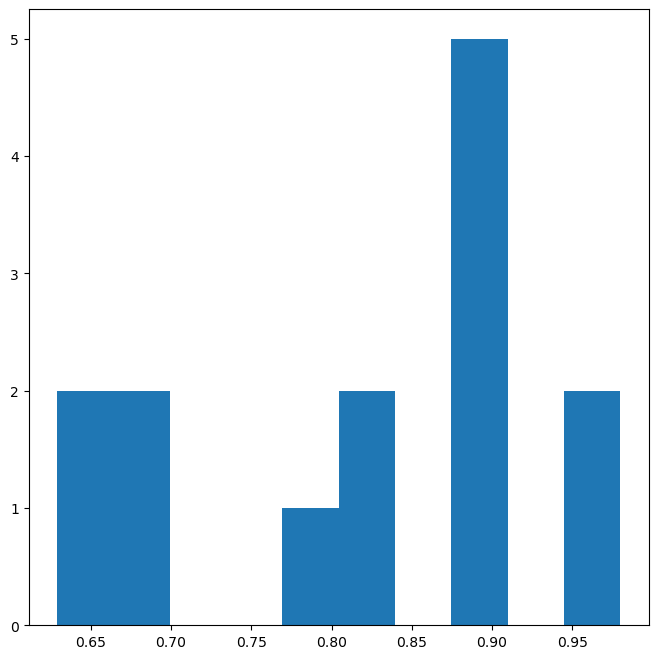

In [203]:
plt.hist(hg_genes_se)

In [209]:
hcc_genes_se = nucSE[nucSE['gene_ID'].isin(clust_hcc)]['Nuclear']

(array([1., 0., 0., 1., 1., 1., 1., 3., 8., 7.]),
 array([0.41378936, 0.46918462, 0.52457987, 0.57997513, 0.63537039,
        0.69076565, 0.7461609 , 0.80155616, 0.85695142, 0.91234668,
        0.96774194]),
 <BarContainer object of 10 artists>)

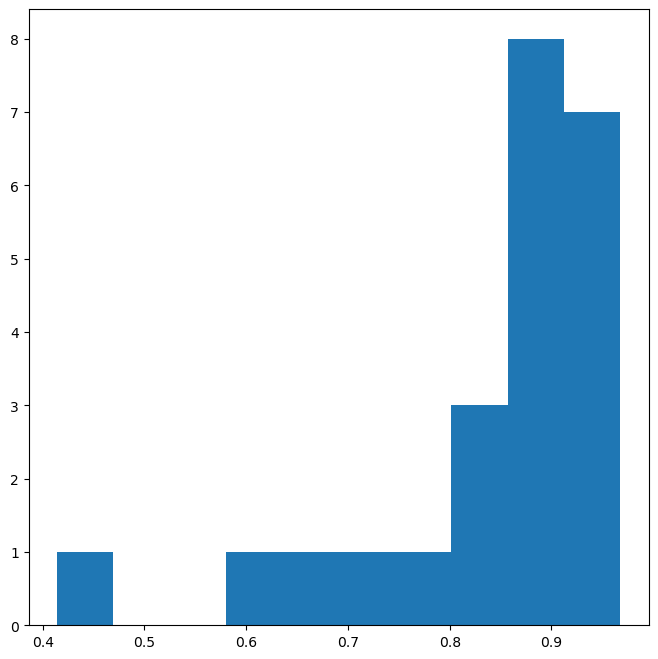

In [212]:
plt.hist(hcc_genes_se)